In [2]:
import numpy as np
import pandas as pd
from typing import Tuple

def pic50_to_dg(
    pic50: float,
    uncertainty: float,
    temperature: float = 298.15
) -> Tuple[float, float]:
    """
    Convert the PIC50 value and its uncertainty to dg.

    Notes:
        We use a different function for this due to the slightly different error propagation formula.
        uncertainty calculated using:
        G = RTLn(Ki)
        Ki = 10^(-pK)
        sigma(G) = dG/dKi * sigma(Ki)
        sigma(G) = sigma(pK) * RT * d Ln(10^-pK) / dpK
        sigma(G) = sigma(pK) * RT * Ln(10)

    Args:
        pic50: The pIC50 value.
        uncertainty: The standard deviation in the pIC50 value
        temperature: Experimental temperature. Default: 298.15 * unit.kelvin.

    Returns:
        dg: Gibbs binding free energy.
        ddg: Error in binding free energy.
    """
    R_kcal = 0.0019872041  # Gas constant in kcal/(mol*K)
    
    # Convert PIC50 to Ki (inhibition constant)
    ki = 10 ** (-pic50)  # Molar

    # Calculate ΔG
    dg = R_kcal * temperature * np.log(ki)

    # Calculate the uncertainty in ΔG
    ddg = R_kcal * temperature * np.log(10) * uncertainty

    return dg, ddg


## BALM vs Docking vs FEP (Zero Shot)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import os

file_path = 'SYK_ZeroShot_Final.csv'
data = pd.read_csv(file_path)

uncertainty_value=0.1
data['label_dG'] = data.apply(lambda row: pic50_to_dg(row['label'], uncertainty_value)[0], axis=1)
data['prediction_dG'] = data.apply(lambda row: pic50_to_dg(row['prediction'], uncertainty_value)[0], axis=1)

#  Adjust calc_DG by adding mean of 'label_dG' to de-centralize it
data['updated_calc_DG'] = data['calc_DG'] + np.mean(data['label_dG'])

# Calculate correlations and RMSE
# BALM (Machine Learning) stats
pearson_corr_balm, _ = pearsonr(data['label_dG'], data['prediction_dG'])
spearman_corr_balm, _ = spearmanr(data['label_dG'], data['prediction_dG'])
kendall_corr_balm, _ = kendalltau(data['label_dG'], data['prediction_dG'])
rmse_balm = np.sqrt(mean_squared_error(data['label_dG'], data['prediction_dG']))

# Docking stats
pearson_corr_docking, _ = pearsonr(data['label_dG'], data['docking_score'])
spearman_corr_docking, _ = spearmanr(data['label_dG'], data['docking_score'])
kendall_corr_docking, _ = kendalltau(data['label_dG'], data['docking_score'])
rmse_docking = np.sqrt(mean_squared_error(data['label_dG'], data['docking_score']))

# FEP stats
pearson_corr_fep, _ = pearsonr(data['label_dG'], data['updated_calc_DG'])
spearman_corr_fep, _ = spearmanr(data['label_dG'], data['updated_calc_DG'])
kendall_corr_fep, _ = kendalltau(data['label_dG'], data['updated_calc_DG'])
rmse_fep = np.sqrt(mean_squared_error(data['label_dG'], data['updated_calc_DG']))

#  Table Data
table_data = [
    ["Metric", "BALM", "Docking", "FEP"],
    ["Pearson r", f"{pearson_corr_balm:.2f}", f"{pearson_corr_docking:.2f}", f"{pearson_corr_fep:.2f}"],
    ["Spearman ρ", f"{spearman_corr_balm:.2f}", f"{spearman_corr_docking:.2f}", f"{spearman_corr_fep:.2f}"],
    ["Kendall τ", f"{kendall_corr_balm:.2f}", f"{kendall_corr_docking:.2f}", f"{kendall_corr_fep:.2f}"],
    ["RMSE", f"{rmse_balm:.2f}", f"{rmse_docking:.2f}", f"{rmse_fep:.2f}"]
]

#  Plotting
plt.figure(figsize=(8, 8))

# Scatter plot for BALM predicted ΔG
plt.scatter(data['label_dG'], data['prediction_dG'], color='#6A5ACD', alpha=0.6, s=50, label='BALM (zero-shot)')
# Scatter plot for FEP predicted ΔG (updated)
plt.scatter(data['label_dG'], data['updated_calc_DG'], color='purple', alpha=0.6, s=50, label='FEP')
# Scatter plot for Docking predicted ΔG
plt.scatter(data['label_dG'], data['docking_score'], color='orange', alpha=0.6, s=50, label='Docking (vina)')

# Identity line and shaded bands
x = np.linspace(-15, -4, 100)
plt.plot(x, x, color='grey', linestyle='-', linewidth=5, alpha=0.4)
plt.fill_between(x, x - 1, x + 1, color='grey', alpha=0.2)
plt.fill_between(x, x - 2, x + 2, color='grey', alpha=0.1)

# Set axis limits
plt.xlim(-15, -4)
plt.ylim(-15, -4)

# Label axes
plt.ylabel(r'Predicted $\Delta G$ [kcal/mol]', fontsize=20)
plt.xlabel(r'Experimental $\Delta G$ [kcal/mol]', fontsize=20)

# Increase font size for tick labels
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Add table with custom styling
ax = plt.gca()
table = ax.table(cellText=table_data, cellLoc='center', loc='lower right', bbox=[0.47, 0.02, 0.52, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(10)

# Style table cells
for (row, col), cell in table.get_celld().items():
    cell.set_text_props(color='grey', ha='center')
    cell.PAD = 0.1
    cell.set_linewidth(0)

    # Bold the header
    if row == 0:
        cell.set_text_props(fontweight='bold', fontsize=10)
    elif row > 0 and col > 0:
        try:
            # Bold best values (highest for correlations, lowest for RMSE)
            val_balm = float(table_data[row][1])
            val_docking = float(table_data[row][2])
            val_fep = float(table_data[row][3])
            if row == 4:  # RMSE row
                if (col == 1 and val_balm <= min(val_docking, val_fep)) or \
                   (col == 2 and val_docking <= min(val_balm, val_fep)) or \
                   (col == 3 and val_fep <= min(val_balm, val_docking)):
                    cell.set_text_props(fontweight='bold')
            else:
                if (col == 1 and val_balm >= max(val_docking, val_fep)) or \
                   (col == 2 and val_docking >= max(val_balm, val_fep)) or \
                   (col == 3 and val_fep >= max(val_balm, val_docking)):
                    cell.set_text_props(fontweight='bold')
        except ValueError:
            pass

# Draw rectangle around table and add dotted line
bbox = table.get_window_extent(plt.gcf().canvas.get_renderer())
inv = ax.transAxes.inverted()
bbox = inv.transform(bbox)
x0, y0 = bbox[0]
x1, y1 = bbox[1]

rect = Rectangle((x0 - 0.01, y0), x1 - x0, y1 - y0, linewidth=0.75, edgecolor='grey', facecolor='none', transform=ax.transAxes)
ax.add_patch(rect)

line_y = y0 + (y1 - y0) * 0.8
line = Line2D([x0 - 0.01, x1 - 0.01], [line_y, line_y], color='grey', linestyle='--', linewidth=0.75, transform=ax.transAxes)
ax.add_line(line)


# plt.legend(fontsize=14)
plt.tight_layout()
output_dir = 'plots/'
#plt.savefig(os.path.join(output_dir, 'ZeroShot_Vina.png'), dpi=500, bbox_inches='tight')
plt.show()


### Few-shot 

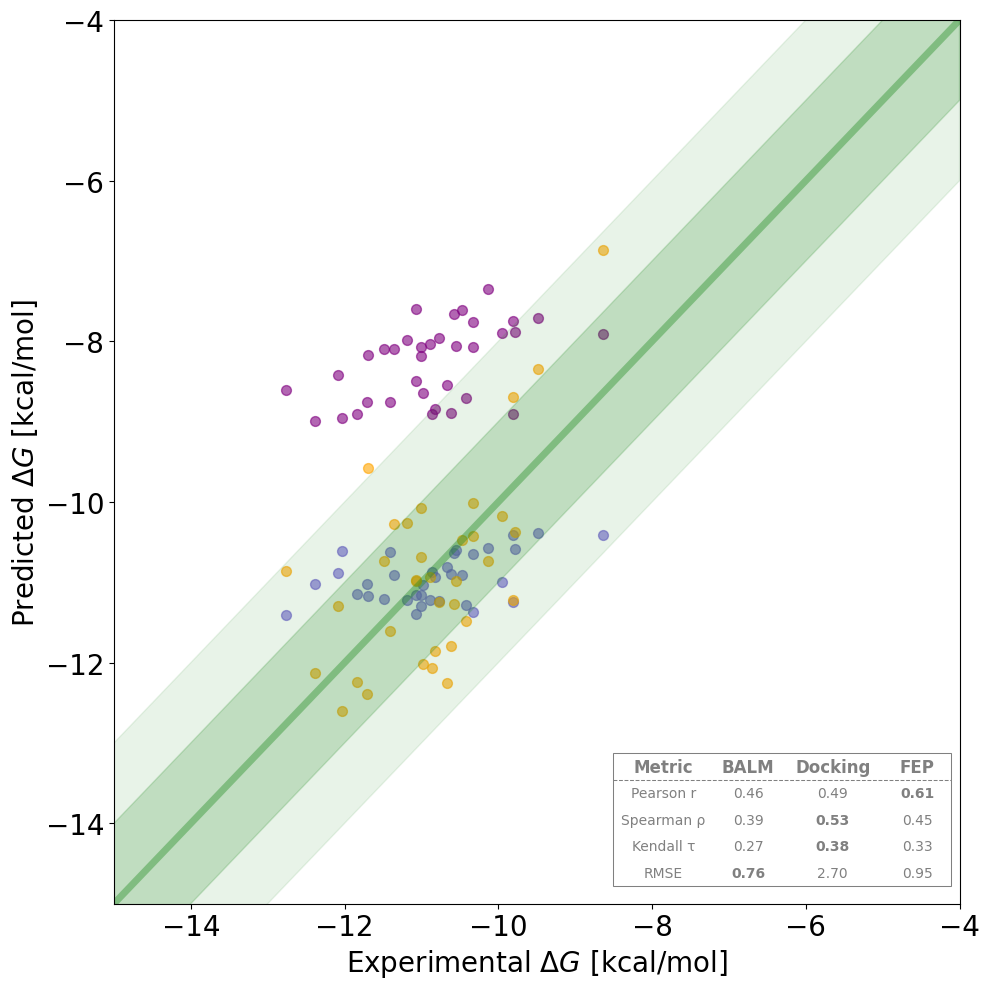

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

data = pd.read_csv('SYK_ZeroShot_Final.csv')
uncertainty_value=0.1
data['label_dG'] = data.apply(lambda row: pic50_to_dg(row['label'], uncertainty_value)[0], axis=1)
data['prediction_dG'] = data.apply(lambda row: pic50_to_dg(row['prediction'], uncertainty_value)[0], axis=1)
data['updated_calc_DG'] = data['calc_DG'] + np.mean(data['label_dG'])
# Load few-shot data
few_shot_data = pd.read_csv('SYK_Few-Shot_Merged_Data.csv')  

# Merge few-shot data with zero-shot data based on 'Molecule_ID_name'
merged_few_shot_data = few_shot_data.merge(data[['Molecule_ID_name','label_dG','updated_calc_DG']], on='Molecule_ID_name', how='left')


# Convert pIC50 to dG for prediction in merged few-shot data
merged_few_shot_data['prediction_dG'] = merged_few_shot_data.apply(lambda row: pic50_to_dg(row['prediction'], uncertainty_value)[0], axis=1)

# Filter out rows with NaN values in label_dG or prediction_dG after the merge
merged_few_shot_data = merged_few_shot_data.dropna(subset=['label_dG', 'prediction_dG', 'docking_score', 'updated_calc_DG'])
# Calculate correlations and RMSE for BALM, Docking, and FEP
# BALM stats
pearson_corr_balm, _ = pearsonr(merged_few_shot_data['label_dG'], merged_few_shot_data['prediction_dG'])
spearman_corr_balm, _ = spearmanr(merged_few_shot_data['label_dG'], merged_few_shot_data['prediction_dG'])
kendall_corr_balm, _ = kendalltau(merged_few_shot_data['label_dG'], merged_few_shot_data['prediction_dG'])
rmse_balm = np.sqrt(mean_squared_error(merged_few_shot_data['label_dG'], merged_few_shot_data['prediction_dG']))

# Docking stats
pearson_corr_docking, _ = pearsonr(merged_few_shot_data['label_dG'], merged_few_shot_data['docking_score'])
spearman_corr_docking, _ = spearmanr(merged_few_shot_data['label_dG'], merged_few_shot_data['docking_score'])
kendall_corr_docking, _ = kendalltau(merged_few_shot_data['label_dG'], merged_few_shot_data['docking_score'])
rmse_docking = np.sqrt(mean_squared_error(merged_few_shot_data['label_dG'], merged_few_shot_data['docking_score']))

# FEP stats
pearson_corr_fep, _ = pearsonr(merged_few_shot_data['label_dG'], merged_few_shot_data['updated_calc_DG'])
spearman_corr_fep, _ = spearmanr(merged_few_shot_data['label_dG'], merged_few_shot_data['updated_calc_DG'])
kendall_corr_fep, _ = kendalltau(merged_few_shot_data['label_dG'], merged_few_shot_data['updated_calc_DG'])
rmse_fep = np.sqrt(mean_squared_error(merged_few_shot_data['label_dG'], merged_few_shot_data['updated_calc_DG']))

# Prepare Table Data
table_data = [
    ["Metric", "BALM", "Docking", "FEP"],
    ["Pearson r", f"{pearson_corr_balm:.2f}", f"{pearson_corr_docking:.2f}", f"{pearson_corr_fep:.2f}"],
    ["Spearman ρ", f"{spearman_corr_balm:.2f}", f"{spearman_corr_docking:.2f}", f"{spearman_corr_fep:.2f}"],
    ["Kendall τ", f"{kendall_corr_balm:.2f}", f"{kendall_corr_docking:.2f}", f"{kendall_corr_fep:.2f}"],
    ["RMSE", f"{rmse_balm:.2f}", f"{rmse_docking:.2f}", f"{rmse_fep:.2f}"]
]

# Plotting
plt.figure(figsize=(10, 10))

# Scatter plot for BALM predicted ΔG
plt.scatter(merged_few_shot_data['label_dG'], merged_few_shot_data['prediction_dG'], color='#6A5ACD', alpha=0.6, s=50, label='BALM (few-shot)')
# Scatter plot for FEP predicted ΔG (updated)
plt.scatter(merged_few_shot_data['label_dG'], merged_few_shot_data['updated_calc_DG'], color='orange', alpha=0.6, s=50, label='FEP')
# Scatter plot for Docking predicted ΔG
plt.scatter(merged_few_shot_data['label_dG'], merged_few_shot_data['docking_score'], color='purple', alpha=0.6, s=50, label='Docking (vina)')

# Identity line and shaded bands
x = np.linspace(-15, -4, 100)
plt.plot(x, x, color='#228B22', linestyle='-', linewidth=5, alpha=0.4)
plt.fill_between(x, x - 1, x + 1, color='#228B22', alpha=0.2)
plt.fill_between(x, x - 2, x + 2, color='#228B22', alpha=0.1)

# Set axis limits
plt.xlim(-15, -4)
plt.ylim(-15, -4)

# Label axes
plt.ylabel(r'Predicted $\Delta G$ [kcal/mol]', fontsize=20)
plt.xlabel(r'Experimental $\Delta G$ [kcal/mol]', fontsize=20)

# Increase font size for tick labels
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Add table with custom styling
ax = plt.gca()
table = ax.table(cellText=table_data, cellLoc='center', loc='lower right', bbox=[0.6, 0.02, 0.4, 0.15])
table.auto_set_font_size(False)
table.set_fontsize(10)

# Style table cells
for (row, col), cell in table.get_celld().items():
    cell.set_text_props(color='grey', ha='center')
    cell.PAD = 0.1
    cell.set_linewidth(0)

    # Bold the header and best values
    if row == 0:
        cell.set_text_props(fontweight='bold', fontsize=12)
    elif row > 0 and col > 0:
        try:
            # Bold best values (highest for correlations, lowest for RMSE)
            val_balm = float(table_data[row][1])
            val_docking = float(table_data[row][2])
            val_fep = float(table_data[row][3])
            if row == 4:  # RMSE row
                if (col == 1 and val_balm <= min(val_docking, val_fep)) or \
                   (col == 2 and val_docking <= min(val_balm, val_fep)) or \
                   (col == 3 and val_fep <= min(val_balm, val_docking)):
                    cell.set_text_props(fontweight='bold')
            else:
                if (col == 1 and val_balm >= max(val_docking, val_fep)) or \
                   (col == 2 and val_docking >= max(val_balm, val_fep)) or \
                   (col == 3 and val_fep >= max(val_balm, val_docking)):
                    cell.set_text_props(fontweight='bold')
        except ValueError:
            pass

# Draw rectangle around table and add dotted line
bbox = table.get_window_extent(plt.gcf().canvas.get_renderer())
inv = ax.transAxes.inverted()
bbox = inv.transform(bbox)
x0, y0 = bbox[0]
x1, y1 = bbox[1]

# Add a rectangle around the table
rect = Rectangle((x0 - 0.01, y0), x1 - x0, y1 - y0, linewidth=0.75, edgecolor='grey', facecolor='none', transform=ax.transAxes)
ax.add_patch(rect)

# Add a dotted line below the table header
line_y = y0 + (y1 - y0) * 0.8
line = Line2D([x0 - 0.01, x1 - 0.01], [line_y, line_y], color='grey', linestyle='--', linewidth=0.75, transform=ax.transAxes)
ax.add_line(line)

# Add legend and show plot
#plt.legend(fontsize=12)
plt.tight_layout()
output_dir = 'plots/'
plt.savefig(os.path.join(output_dir, 'FewShot_Vina.png'), dpi=500, bbox_inches='tight')
plt.show()

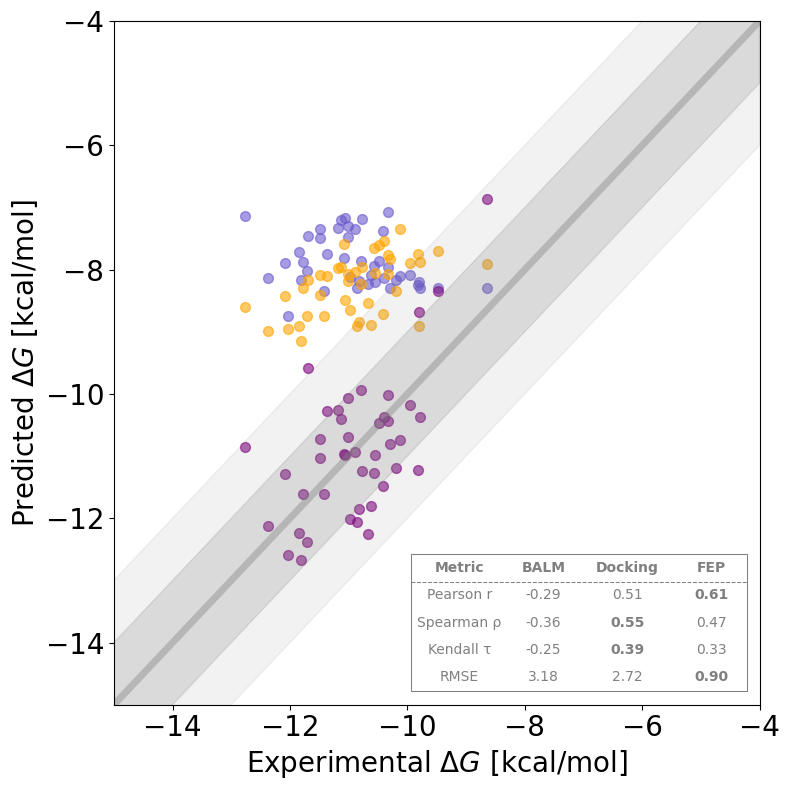

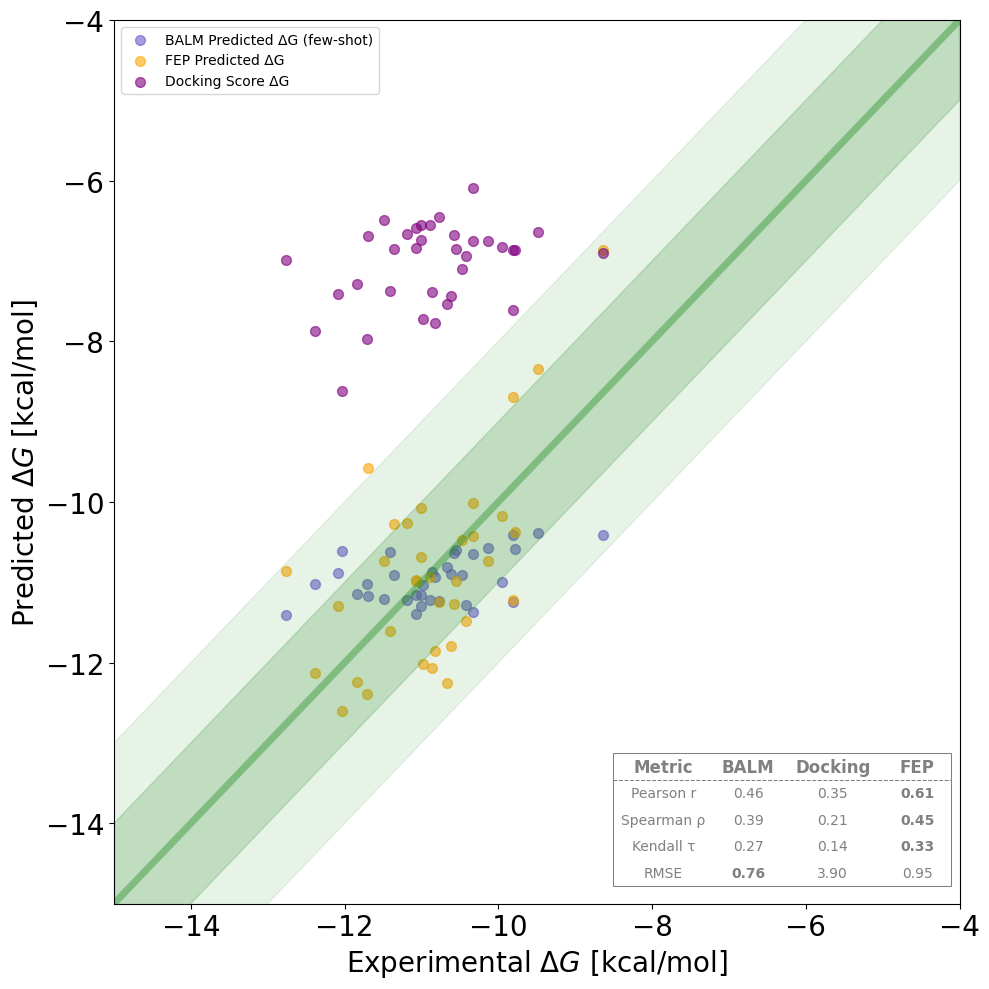

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

data = pd.read_csv('SYK_ZeroShot_Final.csv')
uncertainty_value=0.1
data['label_dG'] = data.apply(lambda row: pic50_to_dg(row['label'], uncertainty_value)[0], axis=1)
data['prediction_dG'] = data.apply(lambda row: pic50_to_dg(row['prediction'], uncertainty_value)[0], axis=1)
data['updated_calc_DG'] = data['calc_DG'] + np.mean(data['label_dG'])
# Load few-shot data
few_shot_data = pd.read_csv('SYK_Few-Shot_Merged_Data.csv')  

# Merge few-shot data with zero-shot data based on 'Molecule_ID_name'
merged_few_shot_data = few_shot_data.merge(data[['Molecule_ID_name','label_dG','updated_calc_DG']], on='Molecule_ID_name', how='left')


# Convert pIC50 to dG for prediction in merged few-shot data
merged_few_shot_data['prediction_dG'] = merged_few_shot_data.apply(lambda row: pic50_to_dg(row['prediction'], uncertainty_value)[0], axis=1)

# Filter out rows with NaN values in label_dG or prediction_dG after the merge
merged_few_shot_data = merged_few_shot_data.dropna(subset=['label_dG', 'prediction_dG', 'docking_score', 'updated_calc_DG'])
# Calculate correlations and RMSE for BALM, Docking, and FEP
# BALM stats
pearson_corr_balm, _ = pearsonr(merged_few_shot_data['label_dG'], merged_few_shot_data['prediction_dG'])
spearman_corr_balm, _ = spearmanr(merged_few_shot_data['label_dG'], merged_few_shot_data['prediction_dG'])
kendall_corr_balm, _ = kendalltau(merged_few_shot_data['label_dG'], merged_few_shot_data['prediction_dG'])
rmse_balm = np.sqrt(mean_squared_error(merged_few_shot_data['label_dG'], merged_few_shot_data['prediction_dG']))

# Docking stats
pearson_corr_docking, _ = pearsonr(merged_few_shot_data['label_dG'], merged_few_shot_data['rDock.Score'])
spearman_corr_docking, _ = spearmanr(merged_few_shot_data['label_dG'], merged_few_shot_data['rDock.Score'])
kendall_corr_docking, _ = kendalltau(merged_few_shot_data['label_dG'], merged_few_shot_data['rDock.Score'])
rmse_docking = np.sqrt(mean_squared_error(merged_few_shot_data['label_dG'], merged_few_shot_data['rDock.Score']))

# FEP stats
pearson_corr_fep, _ = pearsonr(merged_few_shot_data['label_dG'], merged_few_shot_data['updated_calc_DG'])
spearman_corr_fep, _ = spearmanr(merged_few_shot_data['label_dG'], merged_few_shot_data['updated_calc_DG'])
kendall_corr_fep, _ = kendalltau(merged_few_shot_data['label_dG'], merged_few_shot_data['updated_calc_DG'])
rmse_fep = np.sqrt(mean_squared_error(merged_few_shot_data['label_dG'], merged_few_shot_data['updated_calc_DG']))

# Prepare Table Data
table_data = [
    ["Metric", "BALM", "Docking", "FEP"],
    ["Pearson r", f"{pearson_corr_balm:.2f}", f"{pearson_corr_docking:.2f}", f"{pearson_corr_fep:.2f}"],
    ["Spearman ρ", f"{spearman_corr_balm:.2f}", f"{spearman_corr_docking:.2f}", f"{spearman_corr_fep:.2f}"],
    ["Kendall τ", f"{kendall_corr_balm:.2f}", f"{kendall_corr_docking:.2f}", f"{kendall_corr_fep:.2f}"],
    ["RMSE", f"{rmse_balm:.2f}", f"{rmse_docking:.2f}", f"{rmse_fep:.2f}"]
]

# Plotting
plt.figure(figsize=(10, 10))

# Scatter plot for BALM predicted ΔG
plt.scatter(merged_few_shot_data['label_dG'], merged_few_shot_data['prediction_dG'], color='#6A5ACD', alpha=0.6, s=50, label='BALM Predicted ΔG (few-shot)')
# Scatter plot for FEP predicted ΔG (updated)
plt.scatter(merged_few_shot_data['label_dG'], merged_few_shot_data['updated_calc_DG'], color='orange', alpha=0.6, s=50, label='FEP Predicted ΔG')
# Scatter plot for Docking predicted ΔG
plt.scatter(merged_few_shot_data['label_dG'], merged_few_shot_data['rDock.Score'], color='purple', alpha=0.6, s=50, label='Docking Score ΔG')

# Identity line and shaded bands
x = np.linspace(-15, -4, 100)
plt.plot(x, x, color='#228B22', linestyle='-', linewidth=5, alpha=0.4)
plt.fill_between(x, x - 1, x + 1, color='#228B22', alpha=0.2)
plt.fill_between(x, x - 2, x + 2, color='#228B22', alpha=0.1)

# Set axis limits
plt.xlim(-15, -4)
plt.ylim(-15, -4)

# Label axes
plt.ylabel(r'Predicted $\Delta G$ [kcal/mol]', fontsize=20)
plt.xlabel(r'Experimental $\Delta G$ [kcal/mol]', fontsize=20)

# Increase font size for tick labels
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Add table with custom styling
ax = plt.gca()
table = ax.table(cellText=table_data, cellLoc='center', loc='lower right', bbox=[0.6, 0.02, 0.4, 0.15])
table.auto_set_font_size(False)
table.set_fontsize(10)

# Style table cells
for (row, col), cell in table.get_celld().items():
    cell.set_text_props(color='grey', ha='center')
    cell.PAD = 0.1
    cell.set_linewidth(0)

    # Bold the header and best values
    if row == 0:
        cell.set_text_props(fontweight='bold', fontsize=12)
    elif row > 0 and col > 0:
        try:
            # Bold best values (highest for correlations, lowest for RMSE)
            val_balm = float(table_data[row][1])
            val_docking = float(table_data[row][2])
            val_fep = float(table_data[row][3])
            if row == 4:  # RMSE row
                if (col == 1 and val_balm <= min(val_docking, val_fep)) or \
                   (col == 2 and val_docking <= min(val_balm, val_fep)) or \
                   (col == 3 and val_fep <= min(val_balm, val_docking)):
                    cell.set_text_props(fontweight='bold')
            else:
                if (col == 1 and val_balm >= max(val_docking, val_fep)) or \
                   (col == 2 and val_docking >= max(val_balm, val_fep)) or \
                   (col == 3 and val_fep >= max(val_balm, val_docking)):
                    cell.set_text_props(fontweight='bold')
        except ValueError:
            pass

# Draw rectangle around table and add dotted line
bbox = table.get_window_extent(plt.gcf().canvas.get_renderer())
inv = ax.transAxes.inverted()
bbox = inv.transform(bbox)
x0, y0 = bbox[0]
x1, y1 = bbox[1]

# Add a rectangle around the table
rect = Rectangle((x0 - 0.01, y0), x1 - x0, y1 - y0, linewidth=0.75, edgecolor='grey', facecolor='none', transform=ax.transAxes)
ax.add_patch(rect)

# Add a dotted line below the table header
line_y = y0 + (y1 - y0) * 0.8
line = Line2D([x0 - 0.01, x1 - 0.01], [line_y, line_y], color='grey', linestyle='--', linewidth=0.75, transform=ax.transAxes)
ax.add_line(line)

# Add legend and show plot
plt.legend()
plt.tight_layout()
plt.show()


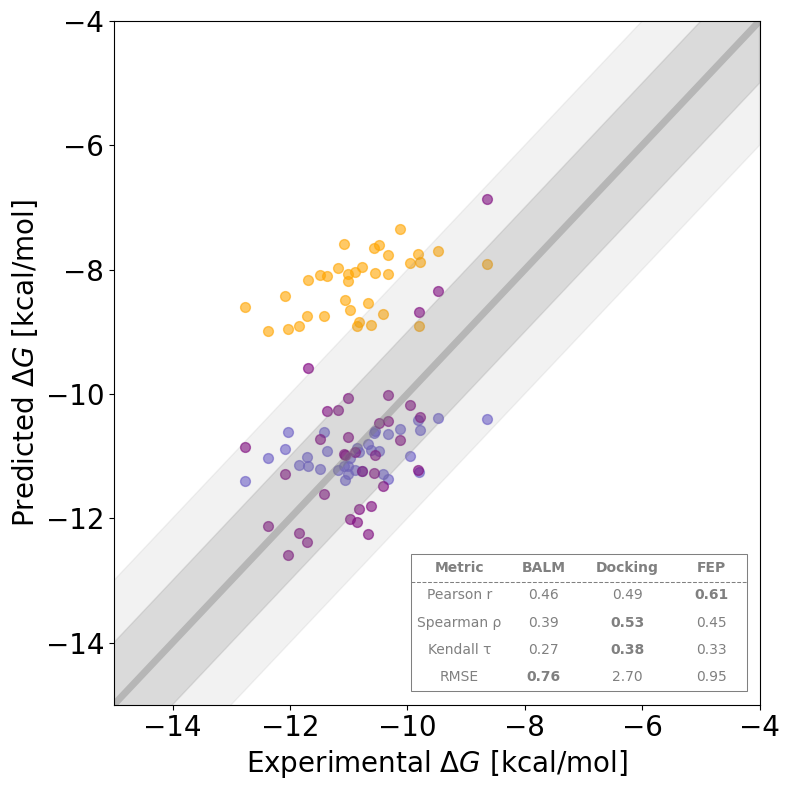

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import os
data = pd.read_csv('SYK_ZeroShot_Final.csv')
uncertainty_value=0.1
data['label_dG'] = data.apply(lambda row: pic50_to_dg(row['label'], uncertainty_value)[0], axis=1)
data['prediction_dG'] = data.apply(lambda row: pic50_to_dg(row['prediction'], uncertainty_value)[0], axis=1)
data['updated_calc_DG'] = data['calc_DG'] + np.mean(data['label_dG'])
# Load few-shot data
few_shot_data = pd.read_csv('SYK_Few-Shot_Merged_Data.csv')  

# Merge few-shot data with zero-shot data based on 'Molecule_ID_name'
merged_few_shot_data = few_shot_data.merge(data[['Molecule_ID_name','label_dG','updated_calc_DG']], on='Molecule_ID_name', how='left')

merged_few_shot_data = merged_few_shot_data.dropna()
# Convert pIC50 to dG for prediction in merged few-shot data
merged_few_shot_data['prediction_dG'] = merged_few_shot_data.apply(lambda row: pic50_to_dg(row['prediction'], uncertainty_value)[0], axis=1)

# Calculate correlations and RMSE for BALM, Docking, and FEP
# BALM stats
pearson_corr_balm, _ = pearsonr(merged_few_shot_data['label_dG'], merged_few_shot_data['prediction_dG'])
spearman_corr_balm, _ = spearmanr(merged_few_shot_data['label_dG'], merged_few_shot_data['prediction_dG'])
kendall_corr_balm, _ = kendalltau(merged_few_shot_data['label_dG'], merged_few_shot_data['prediction_dG'])
rmse_balm = np.sqrt(mean_squared_error(merged_few_shot_data['label_dG'], merged_few_shot_data['prediction_dG']))

# Docking stats
pearson_corr_docking, _ = pearsonr(merged_few_shot_data['label_dG'], merged_few_shot_data['docking_score'])
spearman_corr_docking, _ = spearmanr(merged_few_shot_data['label_dG'], merged_few_shot_data['docking_score'])
kendall_corr_docking, _ = kendalltau(merged_few_shot_data['label_dG'], merged_few_shot_data['docking_score'])
rmse_docking = np.sqrt(mean_squared_error(merged_few_shot_data['label_dG'], merged_few_shot_data['docking_score']))

# FEP stats
pearson_corr_fep, _ = pearsonr(merged_few_shot_data['label_dG'], merged_few_shot_data['updated_calc_DG'])
spearman_corr_fep, _ = spearmanr(merged_few_shot_data['label_dG'], merged_few_shot_data['updated_calc_DG'])
kendall_corr_fep, _ = kendalltau(merged_few_shot_data['label_dG'], merged_few_shot_data['updated_calc_DG'])
rmse_fep = np.sqrt(mean_squared_error(merged_few_shot_data['label_dG'], merged_few_shot_data['updated_calc_DG']))

# Prepare Table Data
table_data = [
    ["Metric", "BALM", "Docking", "FEP"],
    ["Pearson r", f"{pearson_corr_balm:.2f}", f"{pearson_corr_docking:.2f}", f"{pearson_corr_fep:.2f}"],
    ["Spearman ρ", f"{spearman_corr_balm:.2f}", f"{spearman_corr_docking:.2f}", f"{spearman_corr_fep:.2f}"],
    ["Kendall τ", f"{kendall_corr_balm:.2f}", f"{kendall_corr_docking:.2f}", f"{kendall_corr_fep:.2f}"],
    ["RMSE", f"{rmse_balm:.2f}", f"{rmse_docking:.2f}", f"{rmse_fep:.2f}"]
]

# Plotting
plt.figure(figsize=(8,8))

# Scatter plot for BALM predicted ΔG
plt.scatter(merged_few_shot_data['label_dG'], merged_few_shot_data['prediction_dG'], color='#6A5ACD', alpha=0.6, s=50, label='BALM (few-shot)')
# Scatter plot for FEP predicted ΔG (updated)
plt.scatter(merged_few_shot_data['label_dG'], merged_few_shot_data['updated_calc_DG'], color='purple', alpha=0.6, s=50, label='FEP')
# Scatter plot for Docking predicted ΔG
plt.scatter(merged_few_shot_data['label_dG'], merged_few_shot_data['docking_score'], color='orange', alpha=0.6, s=50, label='Docking (vina)')

# Identity line and shaded bands
x = np.linspace(-15, -4, 100)
plt.plot(x, x, color='grey', linestyle='-', linewidth=5, alpha=0.4)
plt.fill_between(x, x - 1, x + 1, color='grey', alpha=0.2)
plt.fill_between(x, x - 2, x + 2, color='grey', alpha=0.1)

# Set axis limits
plt.xlim(-15, -4)
plt.ylim(-15, -4)

# Label axes
plt.ylabel(r'Predicted $\Delta G$ [kcal/mol]', fontsize=20)
plt.xlabel(r'Experimental $\Delta G$ [kcal/mol]', fontsize=20)

# Increase font size for tick labels
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Add table with custom styling
ax = plt.gca()
table = ax.table(cellText=table_data, cellLoc='center', loc='lower right', bbox=[0.47, 0.02, 0.52, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(10)

# Step 6: Style table cells
for (row, col), cell in table.get_celld().items():
    cell.set_text_props(color='grey', ha='center')
    cell.PAD = 0.1
    cell.set_linewidth(0)

    # Bold the header
    if row == 0:
        cell.set_text_props(fontweight='bold', fontsize=10)
    elif row > 0 and col > 0:
        try:
            # Bold best values (highest for correlations, lowest for RMSE)
            val_balm = float(table_data[row][1])
            val_docking = float(table_data[row][2])
            val_fep = float(table_data[row][3])
            if row == 4:  # RMSE row
                if (col == 1 and val_balm <= min(val_docking, val_fep)) or \
                   (col == 2 and val_docking <= min(val_balm, val_fep)) or \
                   (col == 3 and val_fep <= min(val_balm, val_docking)):
                    cell.set_text_props(fontweight='bold')
            else:
                if (col == 1 and val_balm >= max(val_docking, val_fep)) or \
                   (col == 2 and val_docking >= max(val_balm, val_fep)) or \
                   (col == 3 and val_fep >= max(val_balm, val_docking)):
                    cell.set_text_props(fontweight='bold')
        except ValueError:
            pass
        
# Draw rectangle around table and add dotted line
bbox = table.get_window_extent(plt.gcf().canvas.get_renderer())
inv = ax.transAxes.inverted()
bbox = inv.transform(bbox)
x0, y0 = bbox[0]
x1, y1 = bbox[1]

# Add a rectangle around the table
rect = Rectangle((x0 - 0.01, y0), x1 - x0, y1 - y0, linewidth=0.75, edgecolor='grey', facecolor='none', transform=ax.transAxes)
ax.add_patch(rect)

# Add a dotted line below the table header
line_y = y0 + (y1 - y0) * 0.8
line = Line2D([x0 - 0.01, x1 - 0.01], [line_y, line_y], color='grey', linestyle='--', linewidth=0.75, transform=ax.transAxes)
ax.add_line(line)

# Add legend and show plot
# plt.legend(fontsize=14)
plt.tight_layout()
output_dir = 'plots/'
plt.savefig(os.path.join(output_dir, 'FewShot_Vina.png'), dpi=500, bbox_inches='tight')
plt.show()
